# School Project - Twitter Sentiment Analysis 

# 1) Introduction

The task is to build a machine learning model that will predict the sentiment of tweets, negative or positive. 

To do so, we are provided two datasets. First is "MLUnige2021_train", a training dataset with 1'280'000 tweets and the corresponding emotion. Second is "MLUnige2021_test", a test dataset with 320'000 tweets without the corresponding emotion as we want to predict it with our model. 

We'll import relevant modules and the training dataset first.

In [1]:
#General modules
import numpy as np
import pandas as pd
import nltk
import sklearn
#To make plots
import seaborn as sns
import matplotlib.pyplot as plt
#To clean dataset
import re
from nltk.corpus import stopwords
#To count frequency of words
from collections import Counter
from itertools import chain
#For Lemmatization
from nltk.stem import WordNetLemmatizer
#For modelling
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier

#nltk.download("stopwords")

In [2]:
#Import the training data. 
train0 = pd.read_csv("MLUnige2021_train.csv")
train0 #See what the dataset looks like.

,Id,emotion,tweet_id,date,lyx_query,user,text
0,0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...
1,1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...
2,2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...
3,3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...
4,4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...
...,...,...,...,...,...,...,...
1279995,1279995,0,1835296397,Mon May 18 05:39:18 PDT 2009,NO_QUERY,TediousTishia,In second period doing absoultly nothing cuz o...
1279996,1279996,0,2226720395,Thu Jun 18 12:18:05 PDT 2009,NO_QUERY,dani_disaster,is unsure what to do but feels so forgotten
1279997,1279997,1,1962176213,Fri May 29 10:38:30 PDT 2009,NO_QUERY,JonesTheFilm,Waiting around for renders to finish in case t...
1279998,1279998,1,1976894947,Sat May 30 19:28:13 PDT 2009,NO_QUERY,1ChazD,"@kmcooley @LadyProducHer I'm good, suppose to..."


# 2) Feature Engineering

We see that the dataset has many irrelevant features for our prediction task. For example, we want to predict the emotion according to the text in a tweet, so the id of a tweet, the date and the user name won't help us. Moreover, the text in tweets is to be cleaned as well : for example Twitter handles followed by a pseudonym shouldn't help us in predicting emotions, whereas "stopwords" ("I", "the"...), inconsistent grammar/syntax and multiple variations of a word may lead to a number of words too high and unhelpful (e.g "eat" and "eats" should be only treated as "eat" and not two different words, "hello" and "helloooo" as "hello"). 

The rationale behind cleaning the data is to reduce the dimensions of the dataset by keeping only what is relevant. If we don't, we would have too many variables, so not only the computations would take too much time, but we may even end up with too much overfitting. 

For the training set, we also won't work with the whole 1'280'000 tweets due to computational speed. We'll take 30% of it which is a bit higher than the size of the test dataset (25% of 1'280'000). The ratio of positive/negative will remain very similar (around 50%) so our subsample should be representative of the whole dataset. 

First, we will work with a smaller sample and see what words are the most frequent.

<AxesSubplot:xlabel='emotion', ylabel='emotion'>

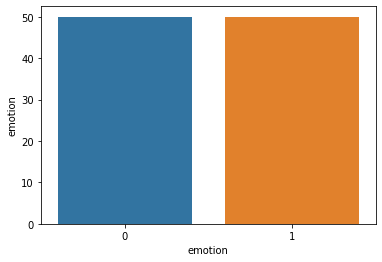

In [3]:
#Remove irrelevant columns
train0 = train0.drop(["date","lyx_query","user", "tweet_id"], axis=1)
#Plot ratio of negative/positive. We see it's balanced.
sns.barplot(x="emotion", y="emotion", data=train0, estimator=lambda x: len(x) / len(train0) * 100)

<AxesSubplot:xlabel='emotion', ylabel='emotion'>

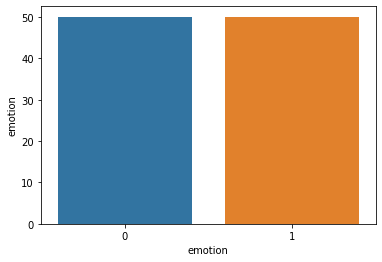

In [4]:
#1'280'000 observations is a bit much. We take 30% of it. We see that the negative/positive ratio is still balanced. 
#So our subsample is representative of the whole sample. 
train1 = train0.sample(frac=.30)
train1 = train1.reset_index(drop=True)

sns.barplot(x="emotion", y="emotion", data=train1, estimator=lambda x: len(x) / len(train1) * 100)

<BarContainer object of 30 artists>

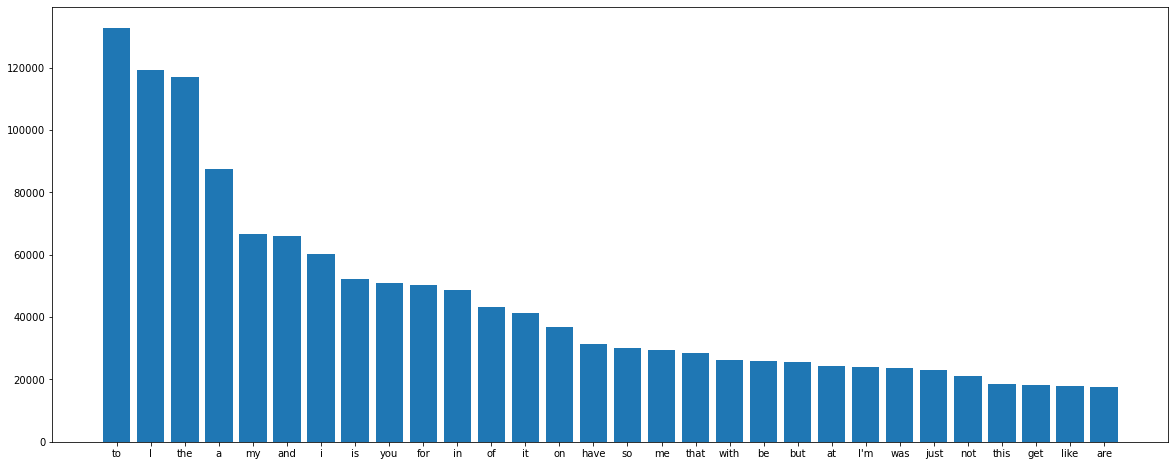

In [5]:
#See 30 most used words. Most of them are irrelevant to help predict emotion, namely "to", "I", the"... 
freq = pd.Series(' '.join(train1['text']).split()).value_counts()[:30]
plt.figure(figsize=(20,8))
plt.bar(freq.index,freq.values)

Then, we'll clean the text in tweets. It goes from removing too small and unfrequent words, to words that shouldn't be related to emotions, among many other steps. They are detailed as the code goes. 

In [6]:
#Here we proceed to clean the data. We'll regularize text as well as removing all irrelevant words.

train1['clean_text'] = train1['text'].str.lower() #Transform to lowercase first for consistency. 

#Here we transform words to make the data handling easier afterwards.   
def decontracted(phrase): 
    phrase = re.sub(r" no ", " not ", phrase) #"no" becomes "not" so it won't be removed by the 2-letters words removal after 
    phrase = re.sub(r"wouldn\'t", "would not", phrase) #For example the english contractions should be transformed
    #in such a way, because for next steps, tokenization&lemmatization may transform "wouldn't" to "wouldn" and "t". And given
    #that, afterwards, we remove words of 1-2 characters, we will lose "t" which originally meant "not".
    phrase = re.sub(r"wouldnt", "would not", phrase) #Correction of grammar mistakes.
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"could\'t", "could not", phrase)
    phrase = re.sub(r"couldnt", "could not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"doesn\'t", "do not", phrase)
    phrase = re.sub(r"doesnt", "do not", phrase)
    phrase = re.sub(r"isn\'t", "is not", phrase)
    phrase = re.sub(r"isnt", "is not", phrase)
    phrase = re.sub(r"hasn\'t", "do not", phrase)
    phrase = re.sub(r"hasnt", "do not", phrase)
    phrase = re.sub(r"haven\'t", "do not", phrase)
    phrase = re.sub(r"havent", "do not", phrase)
    phrase = re.sub(r"aint", "not", phrase)
    phrase = re.sub(r"didn\'t", "do not", phrase)
    phrase = re.sub(r"didnt", "do not", phrase)
    phrase = re.sub(r"hadn\'t", "do not", phrase)
    phrase = re.sub(r"hadnt", "do not", phrase)
    phrase = re.sub(r"wasn\'t", "do not", phrase)
    phrase = re.sub(r"wasnt", "do not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
train1['clean_text'] = np.vectorize(decontracted)(train1['clean_text'])

#We remove URL because they shouldn't help in predicting emotions.
def remove_url(text_data): 
    return re.sub(r"http\S+", "", text_data)
train1['clean_text'] = np.vectorize(remove_url)(train1['clean_text'])

#Remove twitter handles (@user) and hashtag words (#word) for the same reason. 
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
train1['clean_text'] = np.vectorize(remove_pattern)(train1['clean_text'], "@[\w]*")
train1['clean_text'] = np.vectorize(remove_pattern)(train1['clean_text'], "#[\w]*")

#Remove special characters, numbers, punctuations
train1['clean_text'] = train1['clean_text'].str.replace("[^a-zA-Z#]", " ")

#Remove "words" of 1 and 2 letters because they usually don't carry any meaning (except "no" that we have transformed to
#"not" in the steps before). For instance, there aren't many (if any) adjectives with 2 letters only. 
train1['clean_text'] = train1['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#Remove "stopwords". We import a pre-made dictionary that includes many stopwords that shouldn't be relevant to predict emotion.
stopword = nltk.corpus.stopwords.words('english')
stopword.remove('not') #The dictionary we import removes "not" ; here we order it not to remove "not" because we think it's an
                       #important word to keep (e.g. when considering bigrams, "not like" is completely different than "like")
stopword.append('quote') #Irrelevant word.
stopword.append('quot')
stopword.append('lol') #Although "lol" was originally expressed as "laughing" so a positive emotion, it is sometimes used 
                       #negatively now. This "word" is heavily context-dependent and unfortunately our model doesn't really
                       #handle irony. So we remove it.
stopword.append("amp") #We're not sure what this is, but it appeared as a frequent word. We remove it.
train1['clean_text'] = train1['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopword]))

#Remove consecutive duplicate words in a sentence, for example, "jimmy jimmy" -> "jimmy". 
#However, it seems the code doesn't handle for example "jimmy happy jimmy". We don't know how to implement it. 
train1['clean_text'] = train1['clean_text'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')

#Transform 3,4,5(...) consecutive same letters in a row by 2 max (for example, "hellooooooo" -> "helloo").
#There shouldn't be any english words with 3 consecutive same letters. 
def correct_consecutive_letters(phrase):
    phrase = re.sub(r"(.)\1\1+", r"\1", phrase)
    return phrase
train1['clean_text'] = np.vectorize(correct_consecutive_letters)(train1['clean_text'])

#Remove words that appear 5 times or less in the whole dataset. Even if later on our models will use only a certain number
#of words, we use this code so that the computations get a bit faster.
v = train1['clean_text'].str.split().tolist()
c = Counter(chain.from_iterable(v)) 
train1['clean_text'] = [' '.join([j for j in i if c[j] > 5]) for i in v] 

train1.head(10) #Here we can take a look at our cleaned text. Tweets are shorter as many words are removed and changed.

,Id,emotion,text,clean_text
0,305556,1,@nonsequitir That would be great. Hopefully I'...,would great hopefully not used body become use...
1,557103,0,@Autumnrunner my days of running 9 miles are o...,days running miles shin splints doc says need ...
2,673410,0,@ashleyalysa I still love you.,still love
3,702754,0,is already paranoid with the issue! (sick)??? ...,already paranoid issue sick
4,362403,0,Housework day today - boring but necessary!,housework day today boring necessary
5,714920,1,OFFLINE IN ONE MINUTE! GOOD NIGHT WORLD!!! Goo...,offline one minute good night world good night...
6,1266330,0,@_dkm my thoughts exactly,thoughts exactly
7,929793,0,@kgelert LOL! i do eat a lot! but i didn't eat...,eat lot not eat red lobster unfortunately work...
8,996009,0,"cigarette, then cleaning! wow my life is soooo...",cigarette cleaning wow life so interesting
9,1205473,1,http://twitpic.com/5cnhz - Poolin! haha @holy...,haha


In [7]:
#Here we tokenize our text (split sentence into small parts called tokens) so that we can apply lemmatization. 
def tokenization(text):
    text = re.split('\W+', text)
    return text

train1['token_text'] = train1['clean_text'].apply(lambda x: tokenization(x.lower()))

#lemmatization. This is used to transform various forms of a word into the base form 
#(e.g. "want" and "wants" should become "want"). Tokenization was necessary because otherwise,
#lemmatization would split words into letters (e.g "today" -> "t","o","d","a","y" which would be considered as 5 different
#"words".)
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

train1['lemma_text'] = train1["token_text"].apply(lemmatize_text)

#Convert list lemmatext to string
train1['lemma_text_2'] = [' '.join(map(str, l)) for l in train1['lemma_text']]

train1.head(10)

,Id,emotion,text,clean_text,token_text,lemma_text,lemma_text_2
0,305556,1,@nonsequitir That would be great. Hopefully I'...,would great hopefully not used body become use...,"[would, great, hopefully, not, used, body, bec...","[would, great, hopefully, not, used, body, bec...",would great hopefully not used body become use...
1,557103,0,@Autumnrunner my days of running 9 miles are o...,days running miles shin splints doc says need ...,"[days, running, miles, shin, splints, doc, say...","[day, running, mile, shin, splint, doc, say, n...",day running mile shin splint doc say need phys...
2,673410,0,@ashleyalysa I still love you.,still love,"[still, love]","[still, love]",still love
3,702754,0,is already paranoid with the issue! (sick)??? ...,already paranoid issue sick,"[already, paranoid, issue, sick]","[already, paranoid, issue, sick]",already paranoid issue sick
4,362403,0,Housework day today - boring but necessary!,housework day today boring necessary,"[housework, day, today, boring, necessary]","[housework, day, today, boring, necessary]",housework day today boring necessary
5,714920,1,OFFLINE IN ONE MINUTE! GOOD NIGHT WORLD!!! Goo...,offline one minute good night world good night...,"[offline, one, minute, good, night, world, goo...","[offline, one, minute, good, night, world, goo...",offline one minute good night world good night...
6,1266330,0,@_dkm my thoughts exactly,thoughts exactly,"[thoughts, exactly]","[thought, exactly]",thought exactly
7,929793,0,@kgelert LOL! i do eat a lot! but i didn't eat...,eat lot not eat red lobster unfortunately work...,"[eat, lot, not, eat, red, lobster, unfortunate...","[eat, lot, not, eat, red, lobster, unfortunate...",eat lot not eat red lobster unfortunately work...
8,996009,0,"cigarette, then cleaning! wow my life is soooo...",cigarette cleaning wow life so interesting,"[cigarette, cleaning, wow, life, so, interesting]","[cigarette, cleaning, wow, life, so, interesting]",cigarette cleaning wow life so interesting
9,1205473,1,http://twitpic.com/5cnhz - Poolin! haha @holy...,haha,[haha],[haha],haha


From "text" to "lemma_text_2" we see that the tweets are cleaned and shorter. Many words are removed and modified, which translates to less variables. This is what we wanted to have. We can now see which words have the highest frequency now.

<BarContainer object of 30 artists>

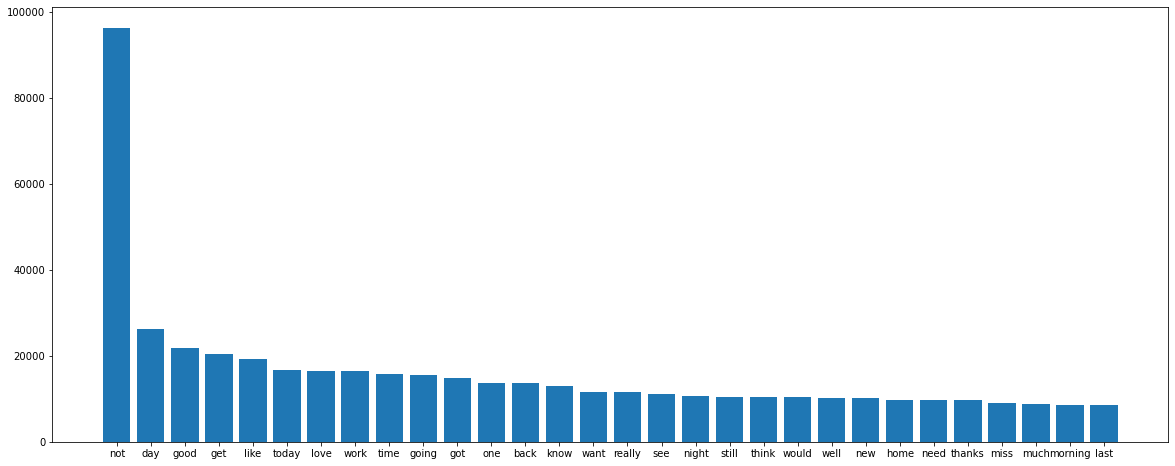

In [8]:
#See 30 most used words. These words should already be more relevant. 
freq2 = pd.Series(' '.join(train1['lemma_text_2']).split()).value_counts()[:30]
plt.figure(figsize=(20,8))
plt.bar(freq2.index,freq2.values)

In [9]:
#We can try to see what words are associated with positive or negative tweets. 
positive = train1["emotion"] == 1
negative = train1["emotion"] == 0
train1_pos = train1[positive]
train1_neg = train1[negative]

<BarContainer object of 30 artists>

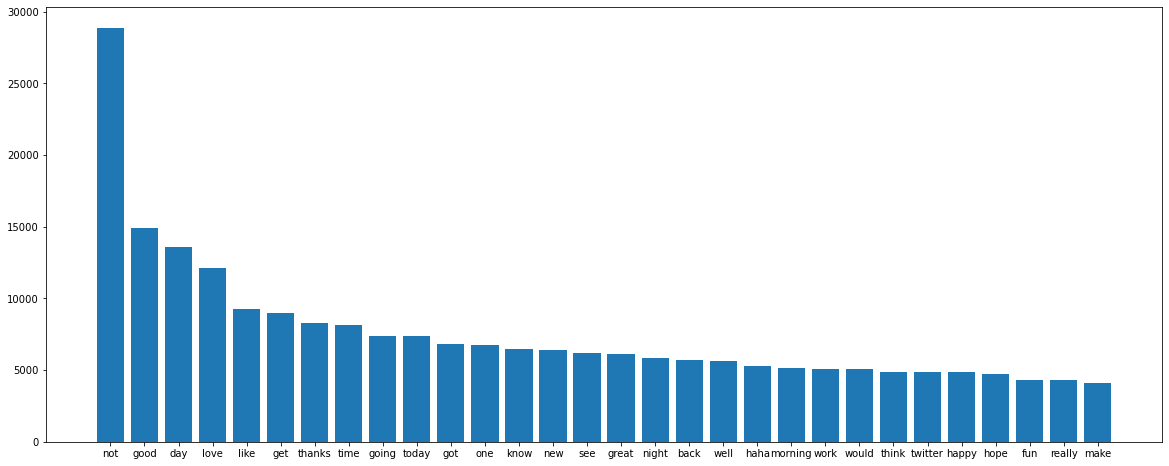

In [10]:
#Frequent words in positive tweets
positive_words = pd.Series(' '.join(train1_pos['lemma_text_2']).split()).value_counts()[:30]
plt.figure(figsize=(20,8))
plt.bar(positive_words.index, positive_words.values)

<BarContainer object of 30 artists>

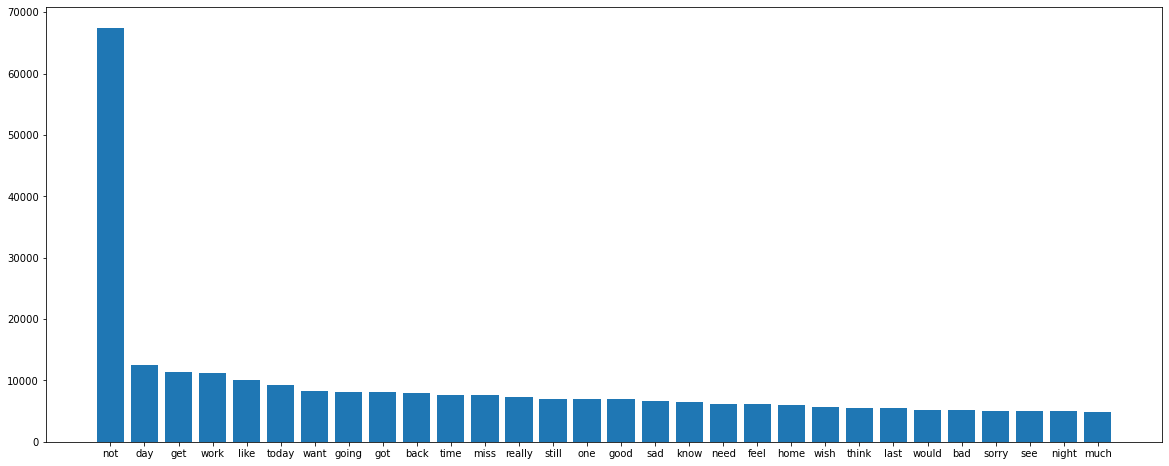

In [11]:
#Frequent words in negative tweets
negative_words = pd.Series(' '.join(train1_neg['lemma_text_2']).split()).value_counts()[:30]
plt.figure(figsize=(20,8))
plt.bar(negative_words.index, negative_words.values)

We see that some words are common in both positive and negative tweets, such as "not", "day", "like"... However, when we'll implement our models we'll make sure that combination of words are possible (bigrams, trigrams). So combinations like "good day" and "bad day" will be most likely present for our models and this simple example shows why "day" would appear in both positive and negative tweets.

# 3) Determining the "best" model 

Now that we have cleaned the data, we can begin our search for the "best" model. 

First, we perform the usual data splitting to get a validation set which will help to assess the accuracy of our models.
Then, we'll perform a GridSearchCV to look for the best hyperparameters both for TFIDF and our prediction model. Unfortunately, we don't look for many combinations of hyperparameters because the computations time will become too large. 

As GridSearchCV is finished, we apply TFIDFVectorizer to X_train and X_test. It first transforms them into "Bag of Words" (intuitively, it transforms words into numbers, so that the machine learning model can work with it) then it applies weights (different weights for the words -- More weight for higher frequency overall, but at the same time penalizing weights if a word appears in too many tweets). Then we use different models to assess their accuracy and decide which one would be the best.

The models we consider are Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Model and Ridge Regression.
These are all models that are computationally fast and seem to perform well here. We considered others models such as Random Forest or Polynomial Support Vector Model, but it was too computationally heavy. Even considering 1000 words(variables) instead of 50000, the models wouldn't finish compiling. 

First, we split the data, create pipelines and apply a Grid Search Cross Validation to find the best values for hyperparameters. There are more specific details in the code. 

In [12]:
#Prepare training and test data.
X = train1["lemma_text_2"]
y = train1["emotion"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 42)

In [13]:
#Here we create a pipeline with GridSearchCV which will returns the best hyperparameters for TFIDF and Logistic regression. 
#TFIDFVectorizer is used to transform words into numbers (also giving them weights)
#so that the machine learning algorithms can work with them.
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("logistic", LogisticRegression()),
])
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], #TFIDF can take into accounts combination of words. It can be important
    #because the combinations can have different meaning (e.g. "do not love" has a negative meaning together whereas separately,
    #their meaning may not be negative). The grid search will look whether it's better to include only unigrams, or adding bigrams
    #and/or trigrams. 
    'tfidf__max_features': (1000,30000, 50000), #TFIDF will look for the X number of words that have the highest 
    #frequency. NB : If we keep adding a higher number of max_features, the GridSearch will
    #almost always suggest the highest. Even if the accuracy keeps increasing, the difference is really small. So we stop
    #at 50000 for balancing computation speed. 
    "logistic__C": (0.5,1,2) #These values have been decided by trial and error.
}

grid_search_tune1 = GridSearchCV(pipeline1, parameters, cv=3, n_jobs=-1, verbose=3)
grid_search_tune1.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune1.best_estimator_.steps)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.9min finished


Best parameters set:
[('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1, 3))), ('logistic', LogisticRegression(C=1))]


C:\Users\jimmy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
#Similar pipeline for Multinomial Naive Bayes.
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("multinb", MultinomialNB()),
])
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': (1000,30000, 50000),
    "multinb__alpha": (3,6,10)
}

grid_search_tune2 = GridSearchCV(pipeline2, parameters, cv=3, n_jobs=-1, verbose=3)
grid_search_tune2.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune2.best_estimator_.steps)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.3min finished


Best parameters set:
[('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1, 3))), ('multinb', MultinomialNB(alpha=6))]


In [15]:
#Similar pipeline for Linear Support Vector Model. 
pipeline3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("linsvc", LinearSVC()),
])
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': (1000,30000, 50000),
    "linsvc__C": (0.01,0.1,1)
}

grid_search_tune3 = GridSearchCV(pipeline3, parameters, cv=3, n_jobs=-1, verbose=3)
grid_search_tune3.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune3.best_estimator_.steps)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.6min finished


Best parameters set:
[('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1, 2))), ('linsvc', LinearSVC(C=0.1))]


In [16]:
#Similar pipeline for Ridge regression. 
pipeline4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("ridge", RidgeClassifier()),
])
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': (1000,30000, 50000),
    "ridge__alpha": (1,10,20)
}

grid_search_tune4 = GridSearchCV(pipeline4, parameters, cv=3, n_jobs=-1, verbose=3)
grid_search_tune4.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune4.best_estimator_.steps)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.4min finished


Best parameters set:
[('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1, 3))), ('ridge', RidgeClassifier(alpha=10))]


In [17]:
When running the notebook, the code stops here so that we can
manually scale the hyperparameters afterwards according to GridSearch.

SyntaxError: invalid syntax (<ipython-input-17-5c9517b7f922>, line 1)

Now that we have the best values for hyperparameters, we'll adjust them in the next steps, then fit the models on the data and assess the accuracy and whether there is overfitting or not.

In [18]:
#Here we define TFIDF with the best hyperparameters given before. Then we apply TFIDF-Vectorizer 
#to our training and test (validation) data. 
tfidf = TfidfVectorizer(max_df=0.90, min_df=2, use_idf=True, ngram_range=(1, 3),max_features=50000)
X_train2 = tfidf.fit_transform(X_train)
X_test2 = tfidf.transform(X_test)

In [19]:
#Similar procedure for LinearSVC whose hyperparameters are slightly different. 
tfidf2 = TfidfVectorizer(max_df=0.90, min_df=2, use_idf=True, ngram_range=(1, 2),max_features=50000)
X_train3 = tfidf2.fit_transform(X_train)
X_test3 = tfidf2.transform(X_test)

In [20]:
#We fit our 4 models to the data.
pipe_logistic = Pipeline(
    [("logistic", LogisticRegression(C=1))]
)
pipe_logistic.fit(X_train2, y_train)

pipe_multinomial_nb = Pipeline(
    [("multinomial_nb", MultinomialNB(alpha=6))]
)
pipe_multinomial_nb.fit(X_train2, y_train)

pipe_linear_svc = Pipeline(
    [("linear_svc", LinearSVC(C=0.1))]
)
pipe_linear_svc.fit(X_train3, y_train)

pipe_ridge = Pipeline(
    [("ridge", RidgeClassifier(alpha=10))]
)
pipe_ridge.fit(X_train2, y_train)

C:\Users\jimmy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ridge', RidgeClassifier(alpha=10))])

In [21]:
#Here we do the predictions and assess the accuracy on training and test data, for each of the 4 models.

#Logit
y_train_logistic_pred=pipe_logistic.predict(X_train2)
acc = accuracy_score(y_train, y_train_logistic_pred)
print("LogisticRegression --- Accuracy on train data:", np.round(acc, 3))

y_test_logistic_pred=pipe_logistic.predict(X_test2)
acc = accuracy_score(y_test, y_test_logistic_pred)
print("LogisticRegression --- Accuracy on test data:", np.round(acc, 3))

#Multinonomial NB
y_train_multinomial_nb_pred=pipe_multinomial_nb.predict(X_train2)
acc = accuracy_score(y_train, y_train_multinomial_nb_pred)
print("MultinomialNB --- Accuracy on train data:", np.round(acc, 3))

y_test_multinomial_nb_pred=pipe_multinomial_nb.predict(X_test2)
acc = accuracy_score(y_test, y_test_multinomial_nb_pred)
print("MultinomialNB --- Accuracy on test data:", np.round(acc, 3))

#Linear SVC
y_train_linear_svc_pred=pipe_linear_svc.predict(X_train3)
acc = accuracy_score(y_train, y_train_linear_svc_pred)
print("LinearSVC --- Accuracy on train data:", np.round(acc, 3))

y_test_linear_svc_pred=pipe_linear_svc.predict(X_test3)
acc = accuracy_score(y_test, y_test_linear_svc_pred)
print("LinearSVC --- Accuracy on test data:", np.round(acc, 3))

#Ridge
y_train_ridge_pred=pipe_ridge.predict(X_train2)
acc = accuracy_score(y_train, y_train_ridge_pred)
print("Ridge --- Accuracy on train data:", np.round(acc, 3))

y_test_ridge_pred=pipe_ridge.predict(X_test2)
acc = accuracy_score(y_test, y_test_ridge_pred)
print("Ridge --- Accuracy on test data:", np.round(acc, 3))

LogisticRegression --- Accuracy on train data: 0.826
LogisticRegression --- Accuracy on test data: 0.794
MultinomialNB --- Accuracy on train data: 0.802
MultinomialNB --- Accuracy on test data: 0.778
LinearSVC --- Accuracy on train data: 0.828
LinearSVC --- Accuracy on test data: 0.793
Ridge --- Accuracy on train data: 0.817
Ridge --- Accuracy on test data: 0.791


For the Kaggle predictions, we'll proceed with the Logistic Regression as it has the highest accuracy on test (validation) data. The model doesn't seem to overfit a lot (not too much difference between accuracy on training data and test data), which is desirable. 

LinearSVC has really similar results, a little bit more training accuracy but a little bit less test accuracy. So it overfits a
little bit more. 

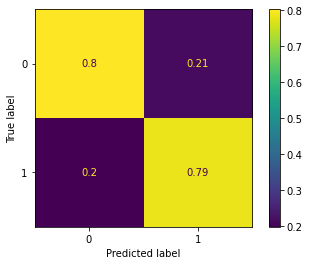

In [22]:
#Plot confusion matrix. We notice we have nearly as much false positive as false negative. This is "good" news as
#our subsample had a balanced negative/positive ratio at the beginning and our predictions on validation set ends up 
#"balanced" too. 
plot_confusion_matrix(pipe_logistic, X_test2, y_test, normalize="pred")  
plt.show()  

In [23]:
classif_report = classification_report(y_test, y_test_logistic_pred)
print(classif_report)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     38410
           1       0.79      0.81      0.80     38390

    accuracy                           0.79     76800
   macro avg       0.79      0.79      0.79     76800
weighted avg       0.79      0.79      0.79     76800



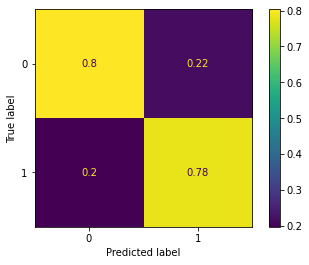

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     38410
           1       0.78      0.81      0.80     38390

    accuracy                           0.79     76800
   macro avg       0.79      0.79      0.79     76800
weighted avg       0.79      0.79      0.79     76800



In [24]:
#We make a confusion matrix and classification report for LinearSVC as well. The ratio of false positive compared to false
#negative is slightly more unbalanced compared to the Logistic Regression. Hence the latter would be prefered.
plot_confusion_matrix(pipe_linear_svc, X_test3, y_test, normalize="pred")  
plt.show()
classif_report = classification_report(y_test, y_test_linear_svc_pred)
print(classif_report)

# 4) Using the best model for the Kaggle predictions

We will load the test dataset, apply the same text cleaning process, the TFIDF procedure and then predict the emotions using our best model, the Logistic Regression. 

In [25]:
#load testdata and remove irrelevant columns
testdata = pd.read_csv("MLUnige2021_test.csv")
testdata = testdata.drop(["date","lyx_query","user", "tweet_id"], axis=1)
testdata

,Id,text
0,0,working add oil
1,1,@KristianaNKOTB you're welcome
2,2,"is going to bed, work in the morning boo but t..."
3,3,@sparky_habbo - uni &amp; assignments happened...
4,4,Can't wait to have chinese food! Still disappo...
...,...,...
319995,319995,@davidgregory How is it that MTP isn't in HiDe...
319996,319996,im thinking about this long shot for a long ti...
319997,319997,@meg___ i feel so old.. i'll be 22 in september
319998,319998,watching supernatural ahah poor they. in jail


In [26]:
#Test data set cleaning.

testdata['text'] = testdata['text'].str.lower()
testdata['text'] = np.vectorize(decontracted)(testdata['text'])
testdata['text'] = np.vectorize(remove_url)(testdata['text'])
testdata['text'] = np.vectorize(remove_pattern)(testdata['text'], "@[\w]*")
testdata['text'] = np.vectorize(remove_pattern)(testdata['text'], "#[\w]*")
testdata['text'] = testdata['text'].str.replace("[^a-zA-Z#]", " ")
testdata['text'] = testdata['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
testdata['text'] = testdata['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopword]))
testdata['text'] = testdata['text'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')
testdata['text'] = np.vectorize(correct_consecutive_letters)(testdata['text'])
v = testdata['text'].str.split().tolist()
c = Counter(chain.from_iterable(v))
testdata['text'] = [' '.join([j for j in i if c[j] > 5]) for i in v]

testdata['text'] = testdata['text'].apply(lambda x: tokenization(x.lower()))
testdata['text'] = testdata["text"].apply(lemmatize_text)
testdata['text'] = [','.join(map(str, l)) for l in testdata['text']]
X2 = tfidf.transform(testdata["text"])
#X3 = tfidf2.transform(testdata["text"])

In [27]:
#Prediction CSV file with Logistic Regression. This will be our main model.

predictions_logistic = pipe_logistic.predict(X2)
my_submission_logistic = pd.DataFrame({'Id': testdata.Id, 'Emotion': predictions_logistic})
my_submission_logistic.to_csv('submission_logistic.csv', index=False)

# 5) Conclusion

After cleaning the training dataset, we tried four different machine learning algorithms and proceeded with a Logistic Regression. Achieving a training accuracy of 82.6% and a test accuracy of 79.4%, we saw that this model doesn't overfit too much and the test accuracy seems good, though it could be improved. 

First, there may be some ways to handle irony, which is something we didn't find a way to account for it. Irony is one, if not the most challenging problem in sentiment analysis ; a machine learning model cannot understand the context of a tweet (which is important to detect sarcasm) without help. If there is a possibility to make the model capable of handling sarcasm, accuracy would probably be higher.  

Then, other models could be considered with adequate use of data (i.e. not too much so that the computations don't take an excessive amount of time), and other words vectorization methods exist as well (Word2Vec, Glove, BERT...).

Therefore, even if our model works quite well, there should be room for improvement. 

# 6) Appendix

In this section, we discuss over miscellaneous topics that we used for the project but not "keeping" them for the final submission. 

<ins> Cloud of Words </ins> 

Instead of a barplot, we can use a cloud of words. First one is for positive tweets and second is for negative tweets.

Though cloud of words are pleasant to look at, we feel that the size of the words don't always match their frequencies, so we prefer using barplots (but we keep the word cloud approach in this appendix, as it's often used in sentiment/word analysis). 

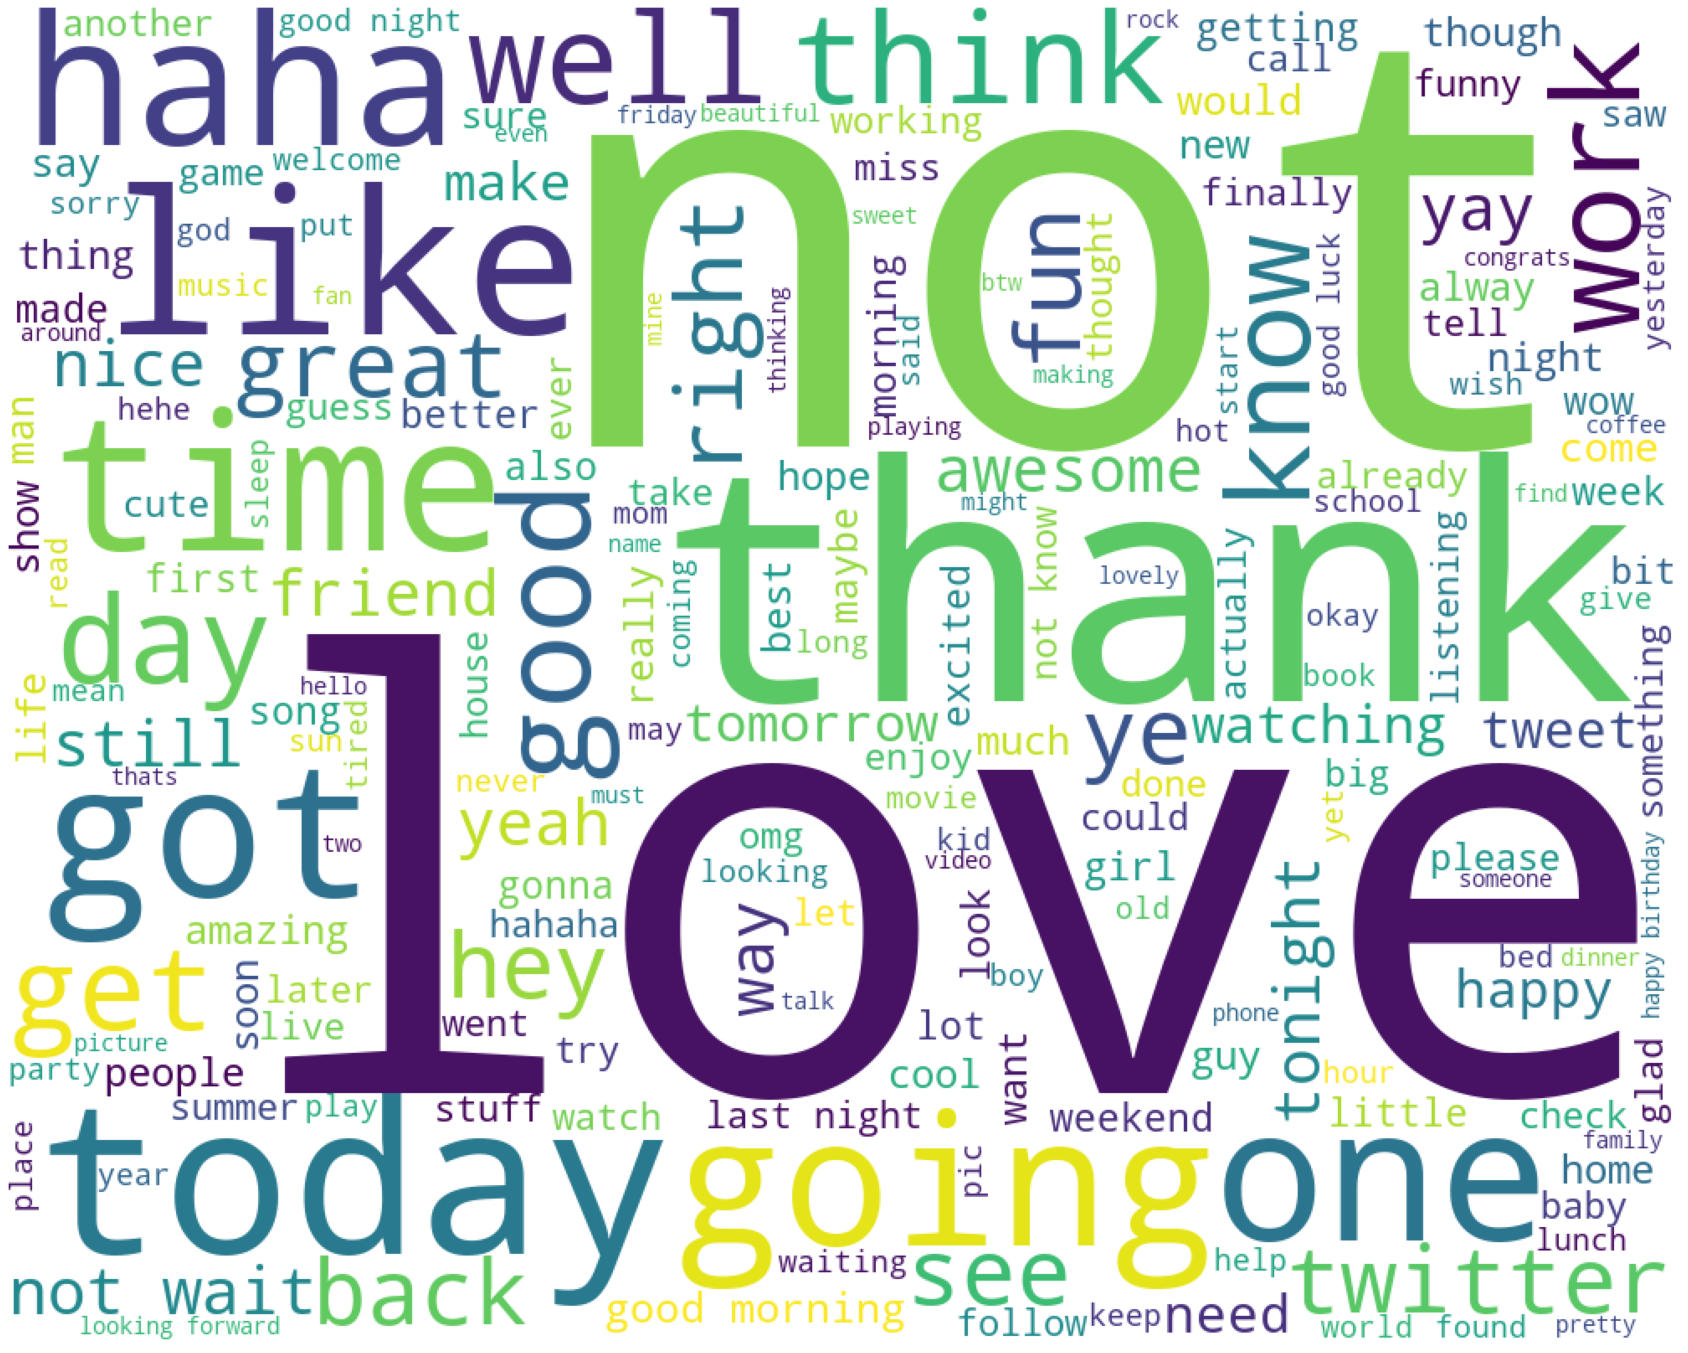

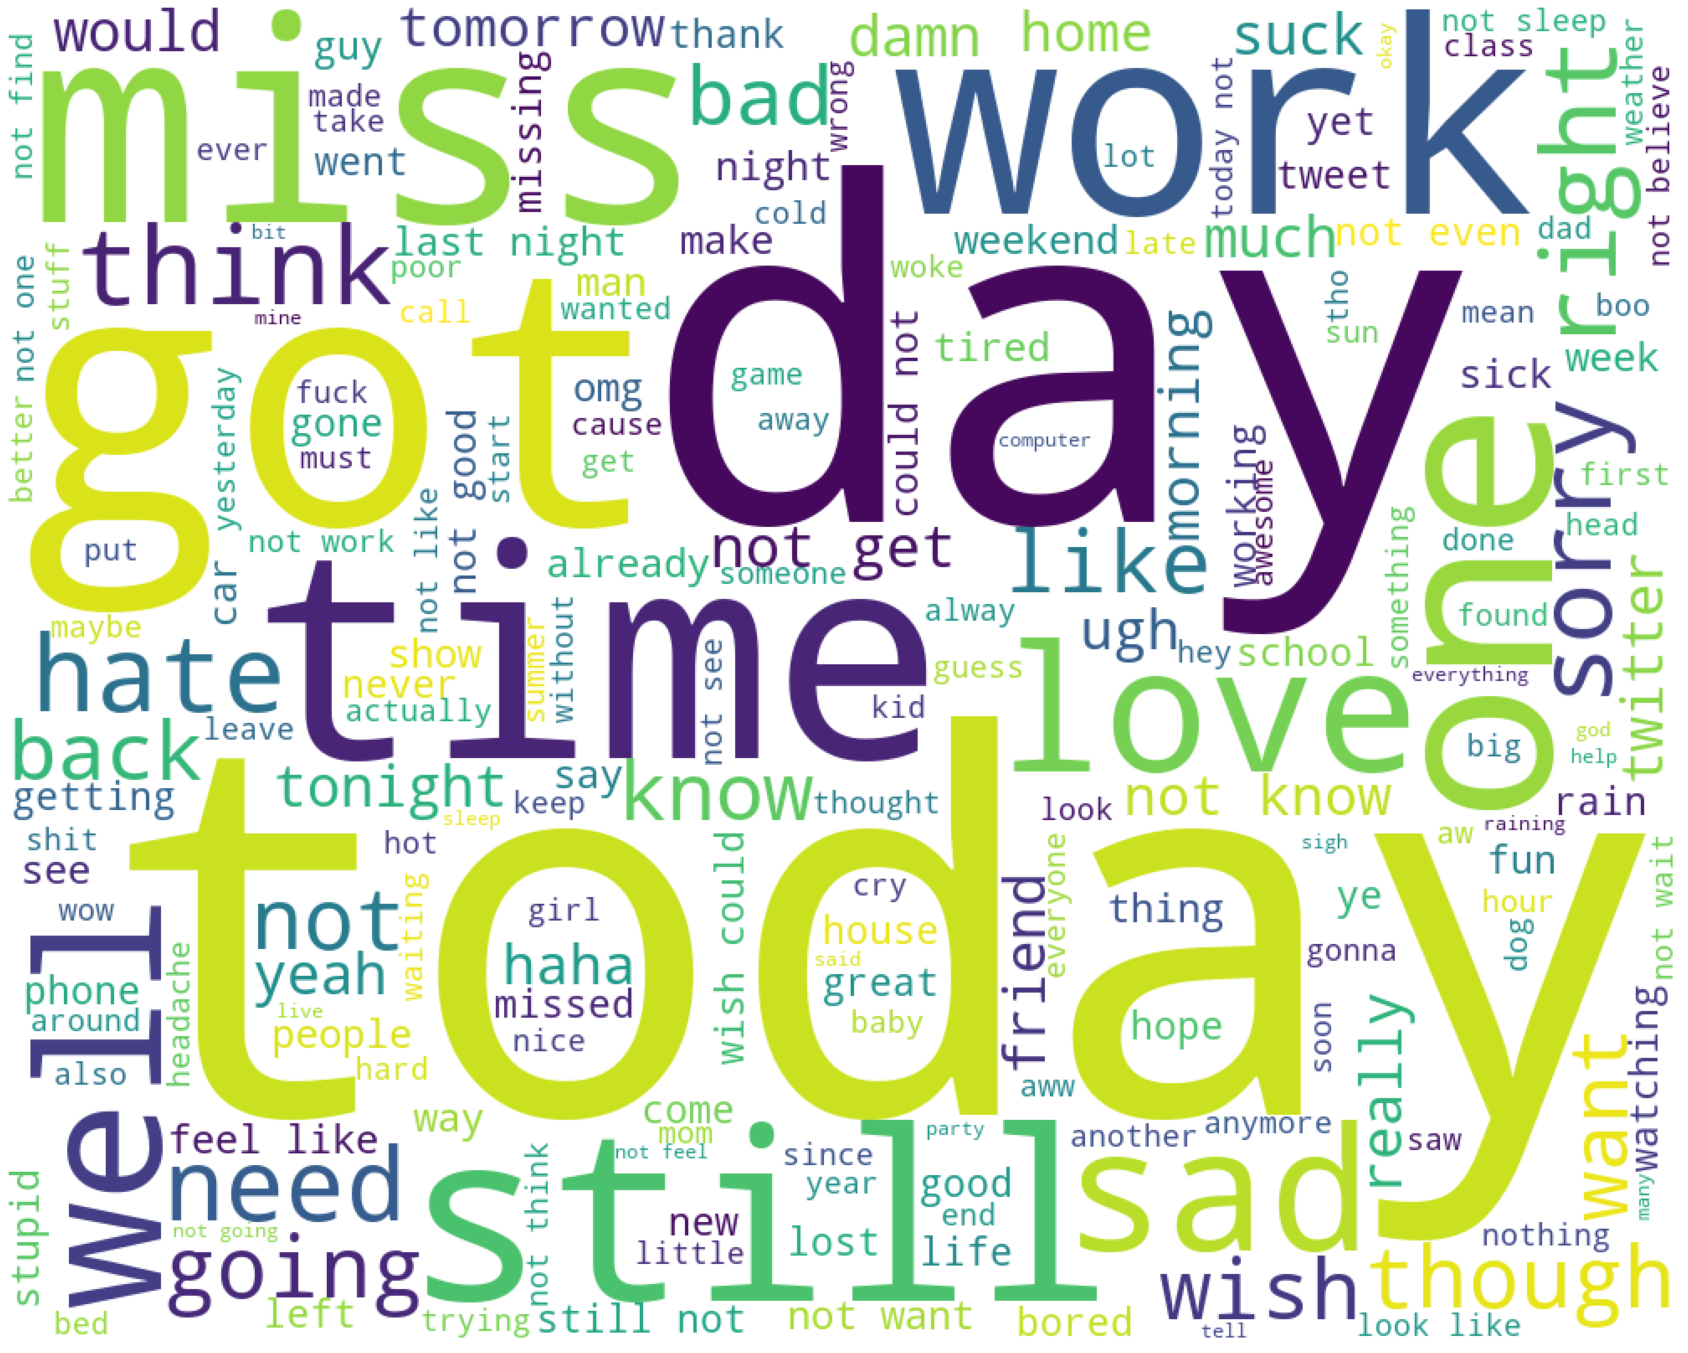

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
def cloud(data,backgroundcolor = 'white', width = 1000, height = 800):
    wordcloud = WordCloud(stopwords=stopword, background_color = backgroundcolor,
                          width = width, height = height).generate(data)
    plt.figure(figsize = (30, 40))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(train1_pos["lemma_text_2"]))
cloud(' '.join(train1_neg["lemma_text_2"]))

<ins> Bag of Words VS Bag of Words and TFIDF </ins> 

We observed that simply using the bag of words method only is a bit worse (but not a huge difference neither) than combining it with TFIDF. So we use the combination which is TFIDF-Vectorizer. 

In [30]:
#We make an experiment with CountVectorizer, which is Bag of words only (so no TFIDF applying weights). We see that 
#train accuracy is a bit higher and test accuracy a bit lower.
#So this is evidence that TFIDFVectorizer (i.e. Bag of Words AND TFIDF) have a bit less overfitting
#than a simple Bag of Words, hence TFIDFVectorizer is preferable. 

from sklearn.feature_extraction.text import CountVectorizer

X_train_BOW, X_test_BOW, y_train_BOW, y_test_BOW = train_test_split(X,y, test_size = .2, random_state = 42)
count_vect = CountVectorizer(max_df=0.90, min_df=2, ngram_range=(1, 3),max_features=50000)
X_train_BOW = count_vect.fit_transform(X_train_BOW)
X_test_BOW = count_vect.transform(X_test_BOW)
# Logistic Regression
# Define pipeline ("scaler", StandardScaler(with_mean=False)), 
pipe_logistic_BOW = Pipeline(
    [("logistic", LogisticRegression(C=1))]
)


# Fit pipeline
pipe_logistic_BOW.fit(X_train_BOW, y_train_BOW)



#Predict and accuracy on the training data
y_train_logistic_pred_BOW=pipe_logistic_BOW.predict(X_train_BOW)
acc = accuracy_score(y_train_BOW, y_train_logistic_pred_BOW)
print("LogisticRegression BagofWords only --- Accuracy on train data:", np.round(acc, 3))

#Predict and accuracy on the test data
y_test_logistic_pred_BOW=pipe_logistic_BOW.predict(X_test_BOW)
acc = accuracy_score(y_test_BOW, y_test_logistic_pred_BOW)
print("LogisticRegression BagofWords only --- Accuracy on test data:", np.round(acc, 3))

LogisticRegression BagofWords only --- Accuracy on train data: 0.838
LogisticRegression BagofWords only --- Accuracy on test data: 0.79


C:\Users\jimmy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<ins> Inconclusive Random Forest </ins>

We wanted to try a Random Forest for our task, but even if we considered using 10000 words instead of 50000 the code wouldn't compile. It was still probably too computationally-heavy. 

It is the same problem for a Polynomial SVM. 

In [31]:
from sklearn.ensemble import RandomForestClassifier
tfidf10 = TfidfVectorizer(max_df=0.90, min_df=2, use_idf=True, ngram_range=(1, 3),max_features=10000)
X_train10 = tfidf10.fit_transform(X_train)
X_test10 = tfidf10.transform(X_test)

In [32]:
pipe_rf = Pipeline([    
    ("rfc", RandomForestClassifier(n_estimators=300, oob_score=True, random_state=1))
])

pipe_rf.fit(X_train10,y_train)


#Predict and accuracy on the training data
y_train_rf_pred=pipe_rf.predict(X_train10)
acc = accuracy_score(y_train, y_train_rf_pred)
print("rfRegression --- Accuracy on train data:", np.round(acc, 3))

#Predict and accuracy on the test data
y_test_rf_pred=pipe_rf.predict(X_test10)
acc = accuracy_score(y_test, y_test_rf_pred)
print("rfRegression --- Accuracy on test data:", np.round(acc, 3))

KeyboardInterrupt: 

In [33]:
#Eventually, setting max_depth = 5 allows us to assess the accuracy of the random forest in a reasonable amount of time, though
#not very fast. The training and test accuracy are both quite poor (probably due to the low max_depth and n_estimators), 
#and performing a grid search takes too much time.
#However we notice that there is almost no difference between train and test accuracy ; compared to Logistic Regression
#and LinearSVC, a Random Forest may be the model with the least overfitting overall. However it is too computationally-heavy.
pipe_rf = Pipeline([    
    ("rfc", RandomForestClassifier(n_estimators=300, oob_score=True, random_state=1, max_depth=5))
])

pipe_rf.fit(X_train10,y_train)


#Predict and accuracy on the training data
y_train_rf_pred=pipe_rf.predict(X_train10)
acc = accuracy_score(y_train, y_train_rf_pred)
print("rfRegression --- Accuracy on train data:", np.round(acc, 3))

#Predict and accuracy on the test data
y_test_rf_pred=pipe_rf.predict(X_test10)
acc = accuracy_score(y_test, y_test_rf_pred)
print("rfRegression --- Accuracy on test data:", np.round(acc, 3))

rfRegression --- Accuracy on train data: 0.722
rfRegression --- Accuracy on test data: 0.718
